In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import pyLDAvis
from gensim import corpora, models
import pyLDAvis.gensim
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
from wordcloud import WordCloud
from sklearn.manifold import TSNE
import pyLDAvis
from gensim import corpora, models
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from operator import itemgetter

### Pulling the Titles

In [3]:
# Define the path to OAuth2 credentials JSON file
creds_path = '/Users/vladandreichuk/Desktop/practical-data-science-tutorial/src/data/credentials.json'

# Define the name of Google Sheet
google_sheet_name = 'Draft-dataset'

# Define the name of the specific sheet within the Google Sheet
specific_sheet_names = ['Health and medical sciences', 'Social sciences', 'Business, economics and management']

# Initialize the Google Sheets client
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(creds_path, scope)
client = gspread.authorize(creds)

article_names = []

for specific_sheet_name in specific_sheet_names:
    # Open the Google Sheet
    sheet = client.open(google_sheet_name).worksheet(specific_sheet_name)

    # Get list of article names from the sheet
    papers = sheet.col_values(3)[1:]

    # Add all article names to a single list
    article_names.extend(papers)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gspread/auth.py:63: DeprecationWarning: [Deprecated][in version 6.0.0]: client_factory will be replaced by gspread.http_client types
  warnings.warn(


In [41]:
article_names[0]

'The psychological impact of quarantine and how to reduce it: rapid review of the evidence'

In [4]:
len(article_names)

1242

### Data Processing

In [7]:
# Download NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vladandreichuk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# Text preprocessing: remove punctuation and stop words
def preprocess_text(text):
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    tokens = [word.lower() for word in tokens if word.lower() not in stopwords.words('english')]
    
    return ' '.join(tokens)

In [9]:
# Apply text preprocessing to the article titles
preprocessed_titles = [preprocess_text(title) for title in article_names]

In [10]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(article_names)

### NMF 

In [4]:
# Define a function named string_to_word_lists that takes a list of strings as input.
def string_to_word_lists(string_list):
    # Initialize an empty list to store word lists.
    word_lists = []

    # Iterate through each string in the input string_list.
    for string in string_list:
        # Split the string into words using whitespace as the delimiter.
        words = string.split()
        
        # Append the list of words to the word_lists list.
        word_lists.append(words)
    
    # Return the word_lists, which contains lists of words from input strings.
    return word_lists

In [11]:
sep_prepr_titles = string_to_word_lists(preprocessed_titles)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gensim/models/nmf.py:578: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gensim/models/nmf.py:607: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gensim/models/nmf.py:607: DeprecationWarning: Please use `csc_matri

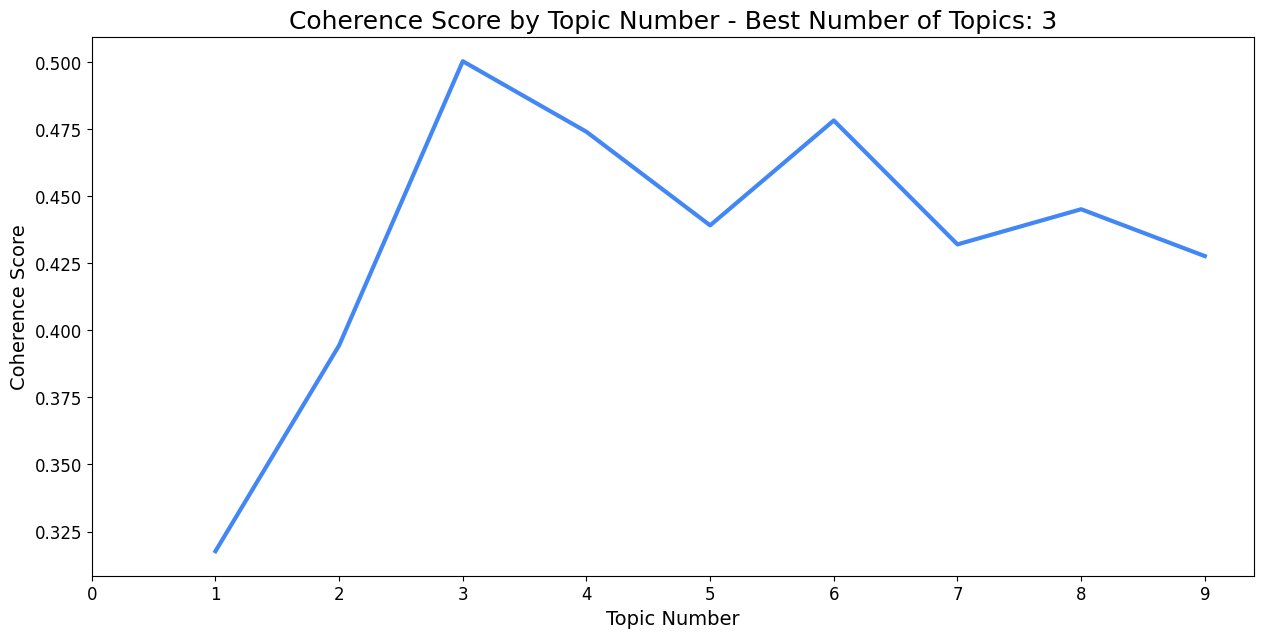

In [13]:
# Use Gensim's NMF to get the best num of topics via coherence score
# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(sep_prepr_titles)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in sep_prepr_titles]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(1, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=sep_prepr_titles,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Number", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)

# Set the x-axis ticks from 0 to 10
plt.xticks(np.arange(0, max(topic_nums) + 1), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [53]:
# NMF Modeling
n_topics = 3
nmf = NMF(n_components=n_topics, init='nndsvd', random_state=1)
nmf.fit(tfidf_matrix)


NMF(init='nndsvd', n_components=3, random_state=1)

In [54]:
# Extract Topics
# Get the feature names (words) that correspond to the columns in the TF-IDF matrix.
feature_names = vectorizer.get_feature_names_out()

# Iterate over the topics identified by NMF and their associated term weights.
for topic_idx, topic in enumerate(nmf.components_):
    # Sort the terms in the topic by their importance (term weight) in descending order and take the top 10.
    top_words_idx = topic.argsort()[:-10 - 1:-1]

    # Extract the actual words (feature names) for the top terms.
    top_words = [feature_names[i] for i in top_words_idx]

    # Print the topic number and the top words that define that topic.
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: covid, 19, patients, pandemic, vaccine, severe, impact, outbreak, effect, study
Topic #2: cancer, trial, phase, randomised, patients, open, label, cell, advanced, plus
Topic #3: innovation, social, role, performance, environmental, green, effects, evidence, energy, media


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


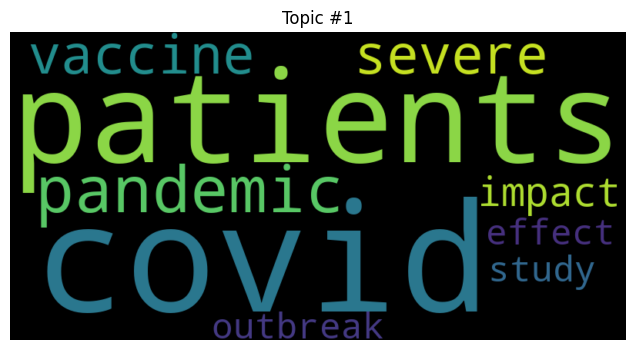

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


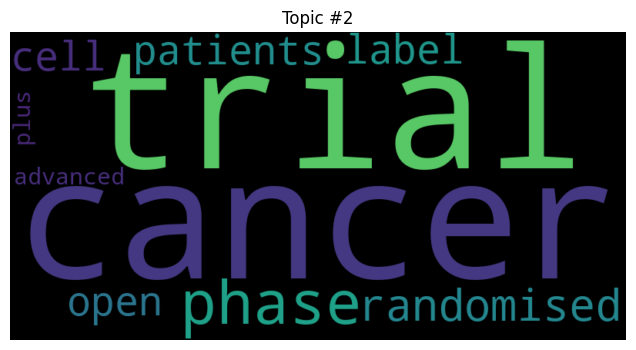

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


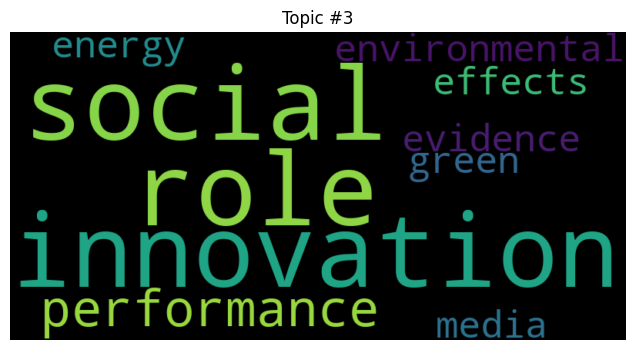

In [55]:
# Visualize Topics using Word Clouds
# Iterate over the topics identified by NMF.
for topic_idx, topic in enumerate(nmf.components_):
    # Sort the terms in the topic by their importance (term weight) in descending order and take the top 10.
    top_words_idx = topic.argsort()[:-10 - 1:-1]

    # Extract the actual words (feature names) for the top terms.
    top_words = [feature_names[i] for i in top_words_idx]
    
    # Create a word cloud for the top words in the current topic.
    wordcloud = WordCloud(width=800, height=400).generate(' '.join(top_words))

    # Create a plot for the word cloud, setting the figure size and interpolation method.
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    
    # Remove axis labels and title the plot with the current topic number.
    plt.axis("off")
    plt.title(f"Topic #{topic_idx + 1}")
    
    # Display the word cloud plot for the current topic.
    plt.show()

In [56]:

# Transform the TF-IDF matrix into NMF embedding, where each document is represented in the NMF topic space.
nmf_embedding = nmf.transform(tfidf_matrix)

# Standardize the NMF embedding by subtracting the mean and dividing by the standard deviation along each topic dimension.
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0)) / nmf_embedding.std(axis=0)


In [58]:
# Sort the documents based on their relevance to the topics and get the indices of the top 5 documents for each topic.
top_idx = np.argsort(nmf_embedding, axis=0)[-5:]

# Initialize a counter to keep track of the current topic number.
count = 0

# Iterate over the indices of the top documents for each topic.
for idxs in top_idx.T:
    # Print the topic number.
    print("\nTopic {}:".format(count))

    # Iterate over the indices of the top documents for the current topic.
    for idx in idxs:
        # Print the preprocessed titles of the top documents.
        print(preprocessed_titles[idx])

    # Increment the topic number for the next iteration.
    count += 1


Topic 0:
covid19 cardiovascular disease
coagulopathy antiphospholipid antibodies patients covid19
competing pandemic retailers ’ ups downs covid19 outbreak
parenting time covid19
risk covid19 patients cancer

Topic 1:
neoadjuvant chemotherapy nivolumab resectable nonsmallcell lung cancer nadim openlabel multicentre singlearm phase 2 trial
neoadjuvant atezolizumab chemotherapy patients resectable nonsmallcell lung cancer openlabel multicentre singlearm phase 2 trial
dacomitinib versus gefitinib firstline treatment patients egfrmutationpositive nonsmallcell lung cancer archer 1050 randomised openlabel phase 3 trial
pembrolizumab versus chemotherapy previously untreated pdl1expressing locally advanced metastatic nonsmallcell lung cancer keynote042 randomised openlabel controlled phase 3 trial
firstline nivolumab plus ipilimumab combined two cycles chemotherapy patients nonsmallcell lung cancer checkmate 9la international randomised openlabel phase 3 trial

Topic 2:
synergy effects innova

Based on the top words and article titles associated with each topic, I have named the three topics as follows:

In [ ]:
topics = ['covid19',
          'drug trials',
          'environmental innovation'
         ]